# Grabbing processed data

In [1]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np
# need to grab mean and std for each column so that we can normalize the df and apply clustering

joined = spark.read.parquet('./../FINAL_processed_data')
print(joined.printSchema())

columns = joined.columns



# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column for normalization
'''
for column in columns:
    if column != 'Season' and column!= 'record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))
'''


# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season' and column!='record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))




root
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- Season: long (nullable = true)
 |-- origin_prcp: long (nullable = true)
 |-- origin_tmax: long (nullable = true)
 |-- origin_tmin: long (nullable = true)
 |-- origin_awnd: long (nullable = true)
 |-- dest_prcp: long (nullable = true)
 |-- dest_tmax: long (nullable = true)
 |-- dest_tmin: long (nullable = true)
 |-- dest_awnd: long (nullable = true)
 |-- record_id: long (nullable = true)

None
Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857406145, origin_long_mean=-92.27161607308254, dest_lat_mean=37.09915724198568, des

## Plotting Locations of Clusters from season =0 (winter) and k=9 and 5 representatives per cluster based on elbow plot

In [2]:
season = 2
k = 9
num_reps = 7
fraction = 0.2

In [3]:
if season !=4:
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
else:
    # then we want all data
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
print(clusters.printSchema())

root
 |-- representative:1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:3: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:4: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:5: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:6: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:7: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [4]:
# selecting origin latitude and longitude of clusters
# these are the fifth and sixth elements of the records

# locations holds DENORMALIZED (latitude, longitude, cluster_id) tuples for representatives in each cluster
origin_locations = []
destination_locations = []
clusters = clusters.collect()
for i,cluster in enumerate(clusters):
    for representative in cluster:
        denormalized_lat = (representative[4] * stats['origin_lat_stddev']) + stats['origin_lat_mean']
        denormalized_long = (representative[5] * stats['origin_long_stddev']) + stats['origin_long_mean']
        denormalized_dest_lat = (representative[6] * stats['dest_lat_stddev'])+ stats['dest_lat_mean']
        denormalized_dest_long = (representative[7] * stats['dest_long_stddev']) + stats['dest_long_mean']
        origin_locations.append((denormalized_lat,denormalized_long,i))
        destination_locations.append((denormalized_dest_lat,denormalized_dest_long,i))
print(origin_locations)

[(39.68433197992258, -97.93504301510565, 0), (38.84706353992259, -80.83834349510569, 0), (49.17643309192256, -90.04287237510566, 0), (27.28183642792262, -56.01005015910576, 0), (45.15209753992257, -62.30667083110575, 0), (27.28183642792262, -56.010050159105745, 0), (50.489488643922556, -101.05603397510563, 0), (44.835425599534744, -74.2567596867963, 1), (42.50386271153475, -83.34881547079628, 1), (45.577664711534744, -79.04770191079629, 1), (42.06392803953476, -79.8656827987963, 1), (42.06392803953476, -79.86568279879629, 1), (46.97021603953474, -82.15122902279629, 1), (45.577664711534744, -79.04770191079629, 1), (44.20996968320377, -66.93820031778102, 2), (40.75407189920377, -106.6914922937809, 2), (25.410403683203818, -61.59308431778102, 2), (40.835903011203776, -106.5681910137809, 2), (43.17067123520377, -67.81475810178101, 2), (43.28066479520377, -67.88970498978101, 2), (40.75407189920377, -106.6914922937809, 2), (44.555449310620325, -62.500108166245454, 3), (29.934047750620365, -1

In [5]:
# getting packages we need
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install shapely

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


     latitude   longitude  cluster_id                     geometry
0   39.684332  -97.935043           0   POINT (-97.93504 39.68433)
1   38.847064  -80.838343           0   POINT (-80.83834 38.84706)
2   49.176433  -90.042872           0   POINT (-90.04287 49.17643)
3   27.281836  -56.010050           0   POINT (-56.01005 27.28184)
4   45.152098  -62.306671           0   POINT (-62.30667 45.15210)
..        ...         ...         ...                          ...
58  33.933629  -87.180399           8   POINT (-87.18040 33.93363)
59  61.800193 -129.196357           8  POINT (-129.19636 61.80019)
60  58.888707 -130.905570           8  POINT (-130.90557 58.88871)
61  66.977609 -136.321423           8  POINT (-136.32142 66.97761)
62  33.933629  -87.180399           8   POINT (-87.18040 33.93363)

[63 rows x 4 columns]


Text(0.5, 1.0, 'Origins of Representatives in Each Cluster ')

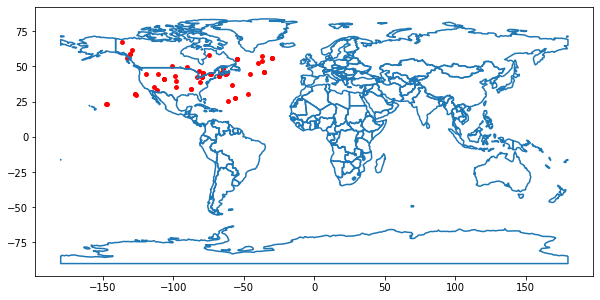

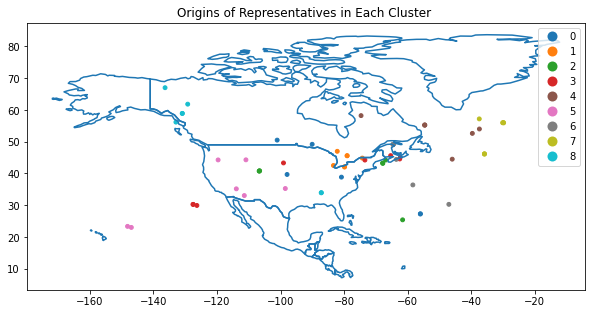

In [6]:
# plotting these latitude longitude values on a map with shapely and geopandas and making a graph for our origin representatives
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt


df = pd.DataFrame(origin_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);
plt.title('Origins of Representatives in Each Cluster ')

     latitude   longitude  cluster_id                     geometry
0   38.847510  -80.843441           0   POINT (-80.84344 38.84751)
1   40.706248  -84.578422           0   POINT (-84.57842 40.70625)
2   50.516351  -92.310229           0   POINT (-92.31023 50.51635)
3   38.847510  -80.843441           0   POINT (-80.84344 38.84751)
4   39.443105  -70.755236           0   POINT (-70.75524 39.44311)
..        ...         ...         ...                          ...
58  58.888877 -130.907639           8  POINT (-130.90764 58.88888)
59  58.888877 -130.907639           8  POINT (-130.90764 58.88888)
60  36.861777  -78.452246           8   POINT (-78.45225 36.86178)
61  61.800363 -129.198426           8  POINT (-129.19843 61.80036)
62  58.888877 -130.907639           8  POINT (-130.90764 58.88888)

[63 rows x 4 columns]


Text(0.5, 1.0, 'Destinations of Representatives In Each Cluster')

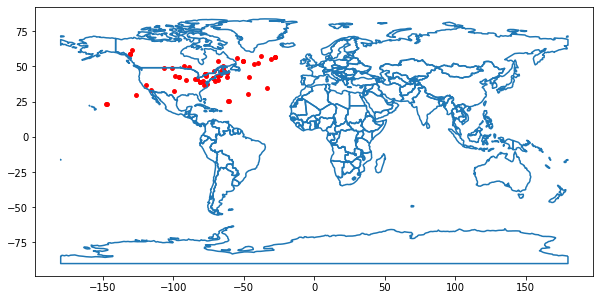

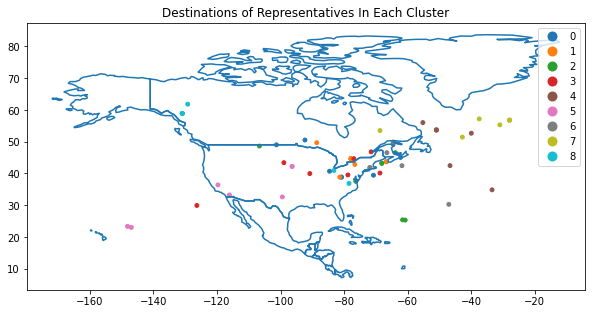

In [7]:
# plotting these latitude longitude values on a map with shapely and geopandas for our destination locations for each representative


df = pd.DataFrame(destination_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);

plt.title('Destinations of Representatives In Each Cluster')

## For each cluster, what is the delay distribution of elements within the cluster?

In [8]:
# grabbing mappings for each cluster for this configuration
if season !=4:
    mapping= spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)).coalesce(1)
else:
    # then we want all data
    mapping = spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)).coalesce(1)
print(mapping.printSchema())

# getting dep delay mean for each cluster in our clustering
# also getting the number of elements in each cluster
# also getting percentages (number of records with delay/all records)
means = []
counts = []
percentages = []
for i in range(len(clusters)):
    if season !=4:
        interested_elements = mapping.where(mapping.tag==i).join(joined.where(joined.Season==season).coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    else:
        interested_elements = mapping.where(mapping.tag==i).join(joined.coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    print('cluster: '+ str(i)+ ' mean depdelay: ' + str(mean))
    means.append(mean['avg(DepDelay)'])
    count = mapping.where(mapping.tag==i).count()
    counts.append(count)
    percentages.append(num_delay/count)
    print('cluster: ' + str(i) + ' number of examples tagged: ' + str(count))
    print('cluster: ' + str(i) + ' number of records with delay: ' + str(num_delay))
    
    
    
    
# getting the mean dep delay for the population and the total count
if season!=4:
    pop_mean = joined.where(joined.Season==season).select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.where(joined.Season==season).count()
else:
    pop_mean  = joined.select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.count()
print('population_mean: ' + str(pop_mean))
print('population count: ' + str(pop_count))




root
 |-- record_id: long (nullable = true)
 |-- tag: integer (nullable = true)

None
cluster: 0 mean depdelay: Row(avg(DepDelay)=65.65889811909051)
cluster: 0 number of examples tagged: 1036573
cluster: 0 number of records with delay: 742334
cluster: 1 mean depdelay: Row(avg(DepDelay)=8.078166097249806)
cluster: 1 number of examples tagged: 7490997
cluster: 1 number of records with delay: 3590625
cluster: 2 mean depdelay: Row(avg(DepDelay)=6.456768071430506)
cluster: 2 number of examples tagged: 3100972
cluster: 2 number of records with delay: 1502884
cluster: 3 mean depdelay: Row(avg(DepDelay)=50.5448240253385)
cluster: 3 number of examples tagged: 129763
cluster: 3 number of records with delay: 93564
cluster: 4 mean depdelay: Row(avg(DepDelay)=21.830260047281325)
cluster: 4 number of examples tagged: 2115
cluster: 4 number of records with delay: 1431
cluster: 5 mean depdelay: Row(avg(DepDelay)=5.354749186839349)
cluster: 5 number of examples tagged: 11532469
cluster: 5 number of rec

## Plotting percentage of records with a delay per cluster

[]

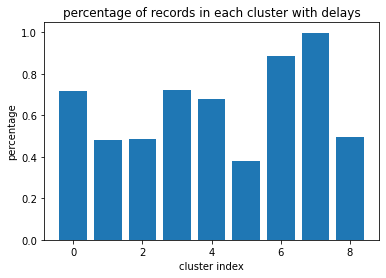

In [9]:
plt.bar([i for i in range(len(percentages))],percentages)
plt.xlabel('cluster index')
plt.ylabel('percentage')
plt.title('percentage of records in each cluster with delays')
plt.plot()

# Plotting number of examples per cluster

[]

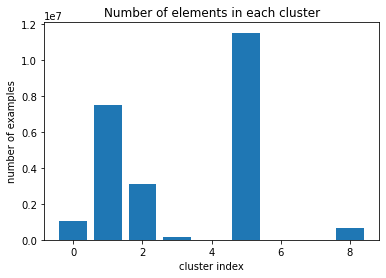

In [10]:
plt.bar([i for i in range(len(counts))],counts)
plt.xlabel('cluster index')
plt.ylabel('number of examples')
plt.title('Number of elements in each cluster')
plt.plot()

## Bar Plot for this Configuration

[]

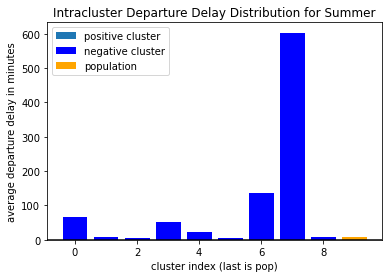

In [11]:

fig = plt.figure()
ax = plt.subplot(111)
positives = []
negatives  = []
for i in range(len(means)):
    if means[i]<0:
        negatives.append((i,means[i]))
    else:
        positives.append((i,means[i]))
#print(zip(*negatives))
first = ax.bar([index for index,value in negatives], [value for index,value in negatives],color='green')
second = ax.bar([index for index,value in positives], [value for index,value in positives],color='blue')
third = ax.bar([len(means)],[pop_mean],color='orange')
ax.axhline(0, color='k')
ax.legend((first,second,third),('positive cluster','negative cluster','population'))
plt.xlabel('cluster index (last is pop)')
plt.ylabel('average departure delay in minutes')
plt.title('Intracluster Departure Delay Distribution for Summer')
plt.plot()

## Cluster analysis for Cluster 6

In [12]:
# intracluster analysis
cluster_index = 6

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
    pop = joined.where(joined.Season==season).drop('Season','record_id')
    pop_stats = pop.select(*[[F.mean(c).alias(c+'_mean') for c in pop.columns] + \
                                     [F.stddev_pop(c).alias(c+'_stddev') for c in pop.columns]]).collect()[0]
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)
    pop_stats = stats

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=143.13690792974987, DepDelay_mean=134.98802554550292, ActualElapsedTime_mean=129.4978712080894, Distance_mean=677.7722192655668, origin_lat_mean=35.51958667214606, origin_long_mean=-83.74234936825698, dest_lat_mean=37.286282321254646, dest_long_mean=-84.90000029438534, origin_prcp_mean=1282.3862426822777, origin_tmax_mean=281.1173496540713, origin_tmin_mean=199.7589143161256, origin_awnd_mean=41.950904736562, dest_prcp_mean=210.453166577967, dest_tmax_mean=289.8102714209686, dest_tmin_mean=196.10311335816925, dest_awnd_mean=39.359632783395426, ArrDelay_stddev=110.27052353671753, DepDelay_stddev=106.40535658430093, ActualElapsedTime_stddev=67.57694938417013, Distance_stddev=520.2589268718089, origin_lat_stddev=6.77346208188801, origin_long_stddev=11.668833328368839, dest_lat_stddev=5.623392440649496, dest_long_stddev=13.858192789841908, origin_prcp_stddev=1178.8522796111586, origin_tmax_stddev=42.76877024850103, origin_tmin_stddev=33.41790946179622, o

## Plotting stats compared to average for delay attributes

In [13]:


# defining a function to make plots for us
def plot_features(labels,title,interested_stats,pop_stats):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    interested_vals = [interested_stats[label+'_mean'] for label in labels]
    interested_stddevs = [interested_stats[label+'_stddev'] for label in labels]
    pop_vals = [pop_stats[label+'_mean'] for label in labels]
    pop_stddevs = [pop_stats[label+'_stddev'] for label in labels]
    indices = np.arange(len(pop_vals))
    width = 0.35
    first = ax.bar(indices,interested_vals,width,label='cluster',yerr=interested_stddevs)
    second = ax.bar(indices+width,pop_vals,width,label='population',yerr=pop_stddevs)
    ax.set_xticks(indices+width/2)
    ax.set_xticklabels(labels)
    plt.ylabel('value')
    plt.xlabel('feature')
    ax.legend((first,second),('Cluster','Population'))
    plt.title(title)
    plt.plot()

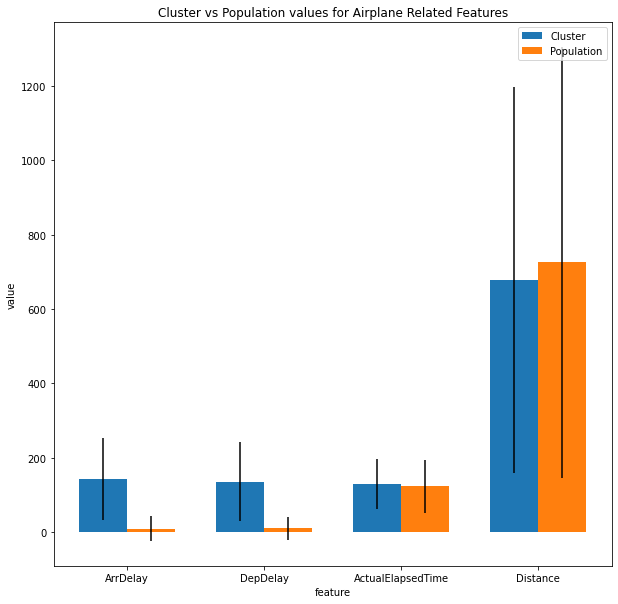

In [14]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

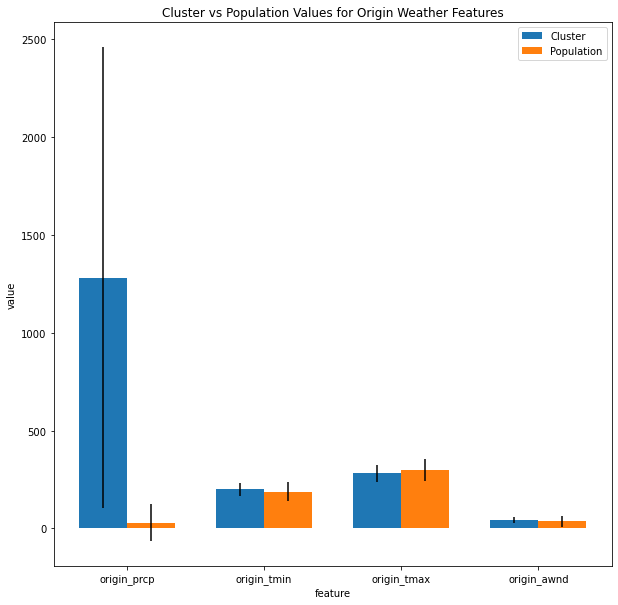

In [15]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

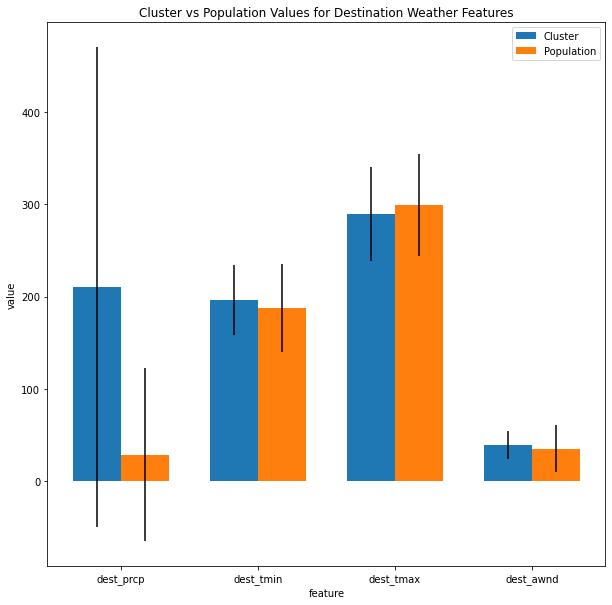

In [16]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## The arrival and destination locations for these flights seem to be affected by the outlier of Guam International Airport. However, we see the usual indicators that the flight is also arriving late, an enormous amount of precipitation, and higher than average windspeed, potentially indicating thunderstorms.

# Analyzing the other cluster with huge delays: cluster 7

In [17]:
# intracluster analysis
cluster_index = 7

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=512.4883720930233, DepDelay_mean=602.9272962179939, ActualElapsedTime_mean=168.37820061075874, Distance_mean=991.9402161146347, origin_lat_mean=37.42417298665258, origin_long_mean=-87.479698114172, dest_lat_mean=37.09656419472398, dest_long_mean=-90.41781187957835, origin_prcp_mean=138.16114634719287, origin_tmax_mean=299.22551092318537, origin_tmin_mean=195.8332158797275, origin_awnd_mean=35.99847310312427, dest_prcp_mean=51.593962884660556, dest_tmax_mean=302.2739018087855, dest_tmin_mean=197.11851068827812, dest_awnd_mean=36.53993422598074, ArrDelay_stddev=250.78669394920638, DepDelay_stddev=309.5566327872101, ActualElapsedTime_stddev=113.14826959829414, Distance_stddev=725.3034348831372, origin_lat_stddev=6.410582711700356, origin_long_stddev=17.584507107537114, dest_lat_stddev=6.193448002451304, dest_long_stddev=17.18939388628776, origin_prcp_stddev=269.7342580975779, origin_tmax_stddev=49.34561088847434, origin_tmin_stddev=42.982726980918045, o

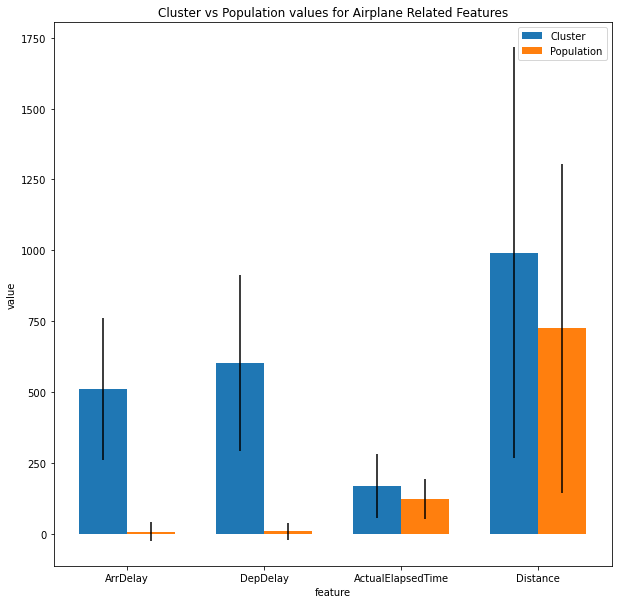

In [18]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

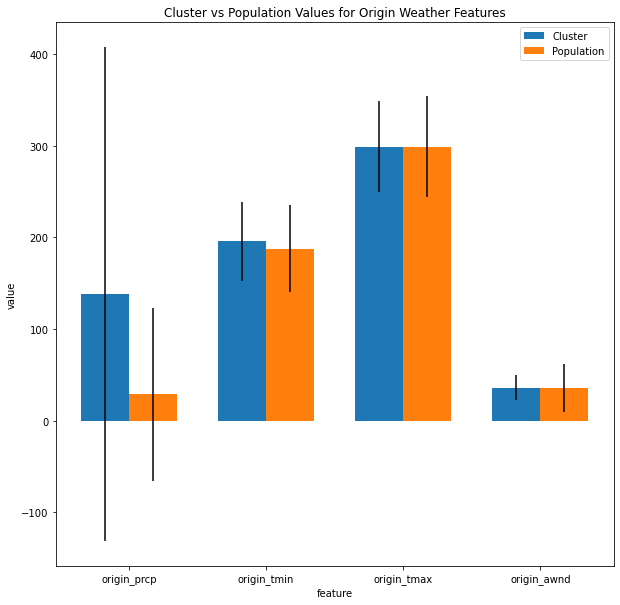

In [19]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

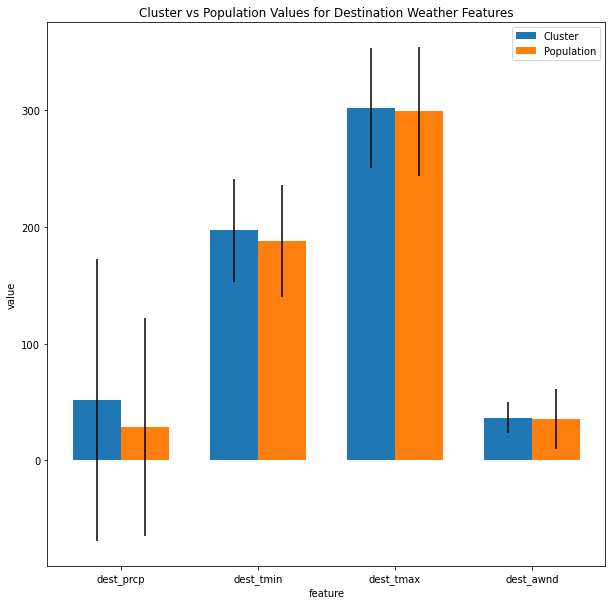

In [20]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## We see a larger than average distance, and a slightly larger than average precipitation amount at the origin. As with before, we also see huge arrival delays.

# Analyzing cluster 0: a cluster with larger than average delay and a significant number of elements relative to the other clusters

In [21]:
# intracluster analysis
cluster_index = 0

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=73.18185598119959, DepDelay_mean=65.65889811909051, ActualElapsedTime_mean=182.59871518937885, Distance_mean=1141.3708364003307, origin_lat_mean=34.94204729401589, origin_long_mean=-88.53145141810917, dest_lat_mean=38.12884969196207, dest_long_mean=-88.17050558267988, origin_prcp_mean=193.11145187073174, origin_tmax_mean=292.9544257857382, origin_tmin_mean=198.0387295443736, origin_awnd_mean=37.62121336365119, dest_prcp_mean=47.75579626326366, dest_tmax_mean=297.09428183060913, dest_tmin_mean=193.06650858164355, dest_awnd_mean=38.902371564761964, ArrDelay_stddev=87.04435694814528, DepDelay_stddev=82.9324070429844, ActualElapsedTime_stddev=90.64490153580216, Distance_stddev=750.2973111532622, origin_lat_stddev=7.01201797512326, origin_long_stddev=15.591033028809157, dest_lat_stddev=4.418108472315706, dest_long_stddev=15.366883698136826, origin_prcp_stddev=247.81067364562182, origin_tmax_stddev=51.106761170985465, origin_tmin_stddev=39.69686449112151, 

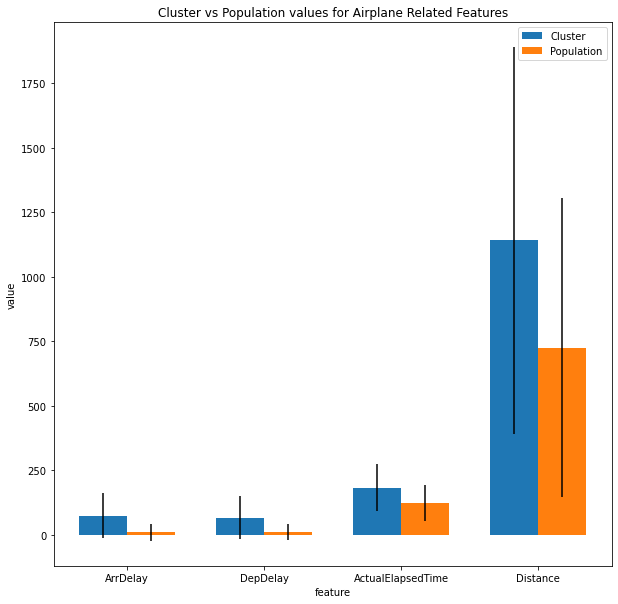

In [22]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

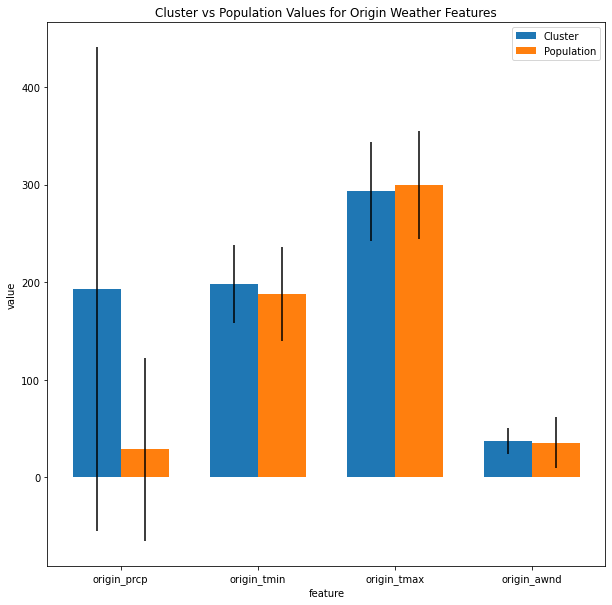

In [23]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

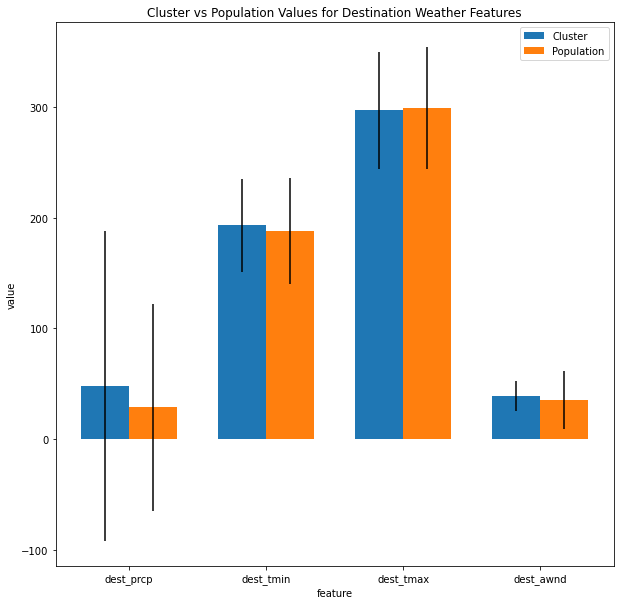

In [24]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

# We see a much higher than average origin precipitation, slightly higher than average windspeeds, and larger than average flight distances. So, far it seems like the most contributing factor to delays is the precipitation amount at the origin and the arrival delay. We do see an arrival delay here as well.